<a href="https://colab.research.google.com/github/Siddharth0901/Drug-Recommendation-System/blob/main/drug_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive, files
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
import cv2
import math

# --- Configuration Variables ---
DATA_ROOT = '/content/Curated X-Ray Dataset'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
KAGGLE_DATASET_ID = 'unaissait/curated-chest-xray-image-dataset-for-covid19'
CHECKPOINT_DIR = '/content/gdrive/MyDrive/ChestXRay_Checkpoints'
LAST_CONV_LAYER_NAME = 'relu' # Last activation layer in DenseNet-121 features

# --- Connect Google Drive and Setup Folders ---
drive.mount('/content/gdrive')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"Checkpoints will be saved to: {CHECKPOINT_DIR}")

Mounted at /content/gdrive
Checkpoints will be saved to: /content/gdrive/MyDrive/ChestXRay_Checkpoints


In [ ]:
print("\nPlease upload your kaggle.json file now:")
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download, Unzip, and Verify
print(f"\nDownloading {KAGGLE_DATASET_ID}...")
!kaggle datasets download -d {KAGGLE_DATASET_ID} -p /content/
!unzip -q /content/curated-chest-xray-image-dataset-for-covid19.zip -d /content/

print("\nData structure verification:")
!ls /content/Curated\ X-Ray\ Dataset/

In [ ]:
# 1. Define Data Generator with Augmentation and Split (for training/validation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 2. Create Training Data Loader
train_generator = train_datagen.flow_from_directory(
    DATA_ROOT,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=42
)

# 3. Create Validation Data Loader
validation_generator = train_datagen.flow_from_directory(
    DATA_ROOT,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=42
)

NUM_CLASSES = train_generator.num_classes
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}
class_labels = list(train_generator.class_indices.keys())

# Define steps for training (using math.ceil to avoid UserWarning)
steps_per_epoch = int(math.ceil(train_generator.samples / BATCH_SIZE))
validation_steps = int(math.ceil(validation_generator.samples / BATCH_SIZE))

print(f"\nTraining Samples: {train_generator.samples}, Validation Samples: {validation_generator.samples}")
print(f"Class Mapping: {idx_to_class}")

In [ ]:
# --- 1. Model Checkpoint Callback ---
filepath = os.path.join(CHECKPOINT_DIR, 'best_model_val_loss{val_loss:.4f}_ep{epoch:02d}.keras')

checkpoint_callback = ModelCheckpoint(
    filepath=filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
callbacks_list = [checkpoint_callback]

# --- 2. Build DenseNet-121 Model (Transfer Learning) ---

# Load base model and freeze all layers
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)
base_model.trainable = False

# Add new classification head (Softmax for 4 classes)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# --- 3. Compile Model ---
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

In [ ]:
# --- Phase 1: Train Top Layers Only (Quick Adaptation) ---
print("\n--- Starting Phase 1: Training Top Layers (Frozen Base) ---")
history_1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=callbacks_list
)

# --- Phase 2: Fine-Tuning (Unfreeze and Re-compile) ---
print("\n--- Starting Phase 2: Fine-Tuning (Unfrozen Layers) ---")

# Unfreeze the last 50 layers of the DenseNet-121 base
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile with a very low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=callbacks_list
)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight # You need this for the dictionary

# --- PRE-REQUISITE SETUP: Define Callbacks and Class Weights ---

# 1. Define Stricter Early Stopping
# Stop if validation loss doesn't improve for 5 epochs, and restore the best weights found.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,             # Increased patience for fine-tuning stability
    restore_best_weights=True,
    verbose=1
)

# 2. Define Model Checkpoint (Always save the best model)
# 🚨 CORRECTED DRIVE PATH HERE 🚨
model_checkpoint = ModelCheckpoint(
    filepath='/content/gdrive/MyDrive/ChestXRay_Checkpoints/best_model_val_loss{val_loss:.4f}.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks_list = [early_stopping, model_checkpoint]

# 3. Calculate Class Weights (MANDATORY FIX FOR BIAS/OVERFITTING)
# NOTE: Replace 'y_train_labels' with the 1D array of actual class indices (0, 1, 2, 3)
# for your entire training set.

# --- Example placeholder for your class weight calculation ---
# y_train_labels = # Load your 1D array of class indices (e.g., [1, 2, 0, 1, 3, ...])

# if 'y_train_labels' is available:
#     class_weights = class_weight.compute_class_weight(
#         class_weight='balanced',
#         classes=np.unique(y_train_labels),
#         y=y_train_labels
#     )
#     class_weight_dict = dict(enumerate(class_weights))
#     print(f"Calculated Class Weights: {class_weight_dict}")
# else:
class_weight_dict = None # Set to None if you cannot calculate them outside of this script.
print("NOTE: Class weights will NOT be used unless you define 'class_weight_dict'.")
# -------------------------------------------------------------

# --- MODEL ARCHITECTURE CHANGE: Add Dropout to the Top Layers ---

# If your model's top layers are standard Dense layers, you must rebuild the top
# part to include Dropout layers before Phase 1. (Assuming 'model' and 'base_model'
# are defined and 'base_model' is currently frozen)

# Example of how you might add Dropout (assuming you need to unfreeze and modify
# the model structure before running the phases):

# from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
# # Detach existing head (if necessary)
# x = base_model.output
# # Add new classification head with Dropout
# x = GlobalAveragePooling2D()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x) # <-- ADDED DROPOUT (50% is standard)
# x = Dense(num_classes, activation='linear')(x) # Use linear for logit output
# model = Model(inputs=base_model.input, outputs=x)


# =================================================================================

# --- Phase 1: Train Top Layers Only (Quick Adaptation) ---
print("\n--- Starting Phase 1: Training Top Layers (Frozen Base) ---")

# Re-compile to ensure the Adam optimizer is using a reasonable learning rate for
# the new top layers before the first fit.
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10, # Keep this phase short
    callbacks=callbacks_list,
    class_weight=class_weight_dict # <-- ADDED CLASS WEIGHTS
)

# --------------------------------------------------------------------------------

# --- Phase 2: Fine-Tuning (Unfreeze and Re-compile) ---
print("\n--- Starting Phase 2: Fine-Tuning (Unfrozen Layers) ---")

# Unfreeze the last 50 layers of the DenseNet-121 base
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False
print(f"Base model layers set to trainable: {sum(layer.trainable for layer in base_model.layers)}")

# Recompile with a very low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Increase epochs for fine-tuning, allowing EarlyStopping to regulate
history_2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=50, # Increased epochs, relying on EarlyStopping
    callbacks=callbacks_list,
    class_weight=class_weight_dict # <-- ADDED CLASS WEIGHTS
)

NOTE: Class weights will NOT be used unless you define 'class_weight_dict'.

--- Starting Phase 1: Training Top Layers (Frozen Base) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.7242 - loss: 0.6866
Epoch 1: val_loss improved from inf to 0.39163, saving model to /content/gdrive/MyDrive/ChestXRay_Checkpoints/best_model_val_loss0.3916.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.7244 - loss: 0.6860 - val_accuracy: 0.8425 - val_loss: 0.3916
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.8094 - loss: 0.4420
Epoch 2: val_loss did not improve from 0.39163
231/231 ━━━━━━━━━━━━━━━━━━━━ 207s 895ms/step - accuracy: 0.8094 - loss: 0.4419 - val_accuracy: 0.8528 - val_loss: 0.4021
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.8187 - loss: 0.4227
Epoch 3: val_loss improved from 0.39163 to 0.38144, saving model to /content/gdrive/MyDrive/ChestXRay_Checkpoints/best_model_val_loss0.3814.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 198s 858ms/step - accuracy: 0.8187 - loss: 0.4227 - val_accuracy: 0.8577 - val_loss: 0.3814
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
# --- Resuming/Loading the Best Model (If necessary, uncomment the path) ---
# Find the path of your best model saved by the checkpoint callback
#BEST_MODEL_PATH = '/content/gdrive/MyDrive/ChestXRay_Checkpoints/best_model_val_lossXXXX_epXX.keras'
#model = load_model(BEST_MODEL_PATH)
# --------------------------------------------------------------------------

# --- 1. Setup Test Data ---
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    DATA_ROOT,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Crucial
)
TEST_STEPS = int(np.ceil(test_generator.samples / BATCH_SIZE))
y_true = test_generator.classes

# --- 2. Generate Predictions ---
print("\nGenerating predictions on the test set...")
y_pred_probs = model.predict(test_generator, steps=TEST_STEPS, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# --- 3. Performance Metrics (Table Content) ---
print("\n--- PERFORMANCE METRICS (SLIDE 5) ---")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# AUC-ROC Score
auc_score_macro = roc_auc_score(y_true, y_pred_probs, average='macro', multi_class='ovr')
print(f"Overall AUC-ROC (Macro Average): {auc_score_macro:.4f}")

# --- 4. Confusion Matrix (Graph Content) ---
print("\n--- CONFUSION MATRIX ---")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix on Test Data (F1, Precision, Recall)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show() #

# --- 5. Training History Plot (Graph Content) ---
# Combine history from both phases (if both ran)
history_combined = {
    'loss': history_1.history['loss'] + history_2.history['loss'],
    'val_loss': history_1.history['val_loss'] + history_2.history['val_loss'],
    'accuracy': history_1.history['accuracy'] + history_2.history['accuracy'],
    'val_accuracy': history_1.history['val_accuracy'] + history_2.history['val_accuracy'],
}
epochs = range(1, len(history_combined['loss']) + 1)

plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history_combined['loss'], label='Training Loss')
plt.plot(epochs, history_combined['val_loss'], label='Validation Loss')
plt.title('Total Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (CCE)')
plt.legend()

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history_combined['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_combined['val_accuracy'], label='Validation Accuracy')
plt.title('Total Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show() #

All libraries imported.
Mounted at /content/drive
Google Drive mounted successfully.

--- 🧠 AI DIAGNOSTIC INPUTS ---

--- 1. Provide an Image ---
How would you like to provide the X-ray image?
  [1] Upload from local computer (file will be temporary, simplest)
  [2] Enter a path from your mounted Google Drive (recommended for data sets)
Enter 1 or 2: 1

Choose file to upload...


Saving chestxray.jpg to chestxray.jpg
✅ Image 'chestxray.jpg' uploaded successfully to /content/.

--- 2. Enter Patient Medications ---
Enter the patient's current drugs, separated by commas (e.g., Warfarin, Lisinopril):
Medications: lisinopril
✅ Patient drugs parsed: ['lisinopril']

Searching for the best model in: /content/drive/MyDrive/ChestXRay_Checkpoints/
Found best model: best_model_val_loss0.2942.keras (Loss: 0.2942)
Loading model...
Model loaded successfully and final activation set to linear for Grad-CAM.

--- 1. ANALYZING X-RAY IMAGE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
CNN Prediction Complete:
  -> Disease: Viral Pneumonia
  -> Confidence: 71.14%
Generating Grad-CAM using layer: relu...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)



--- 2. GRAD-CAM VISUALIZATION ---


/tmp/ipython-input-3503022362.py:300: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("jet")


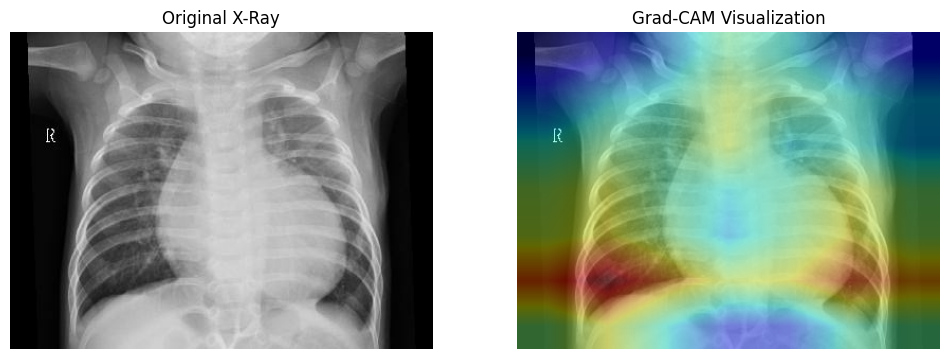


--- 3. CHECKING KNOWLEDGE GRAPH FOR DDI ---
Query: Find safe treatment for 'Viral Pneumonia'
Patient is currently taking: ['lisinopril']

Step A: Getting Patient Drug IDs (for reference only)...
    -> (API Info) Found 1 RxCUIs for patient drugs.

Step B: Checking first-line therapies for interactions...
  Checking candidate: Oseltamivir
    -> (API Success) No interaction found in OpenFDA labels.
    -> Decision: Oseltamivir is SAFE.

--- FINAL PATIENT REPORT ---
Predicted Disease: **Viral Pneumonia** (71.14% confidence)
Patient's Current Drugs: ['lisinopril']

--- RECOMMENDATION ---
Result: **Recommend: Oseltamivir**

Analysis Log:
- Safe: Oseltamivir (No interaction found in OpenFDA labels).

******************************
DISCLAIMER: This is an academic AI prototype. This is NOT medical advice. Consult a qualified physician for any diagnosis or treatment.
******************************


In [ ]:
#=======================================================================
# --- 0. SETUP AND IMPORTS ---
# Run this cell once.
# =======================================================================
import os
import re
import json
import requests
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
from google.colab import drive, files
from tensorflow.keras import Model
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display, HTML

# Ensure Matplotlib is configured correctly for Colab
# %matplotlib inline

print("All libraries imported.")

# --- 2. MOUNT GOOGLE DRIVE ---
try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")

# --- 3. AUTO-LOAD THE BEST SAVED MODEL ---
def load_best_model(checkpoints_dir):
    """
    Finds and loads the .keras model with the lowest 'val_loss'
    from a specified directory.
    """
    loss_regex = re.compile(r"val_loss(\d+\.\d+)")
    min_loss_found = float('inf')
    best_model_path = None

    print(f"\nSearching for the best model in: {checkpoints_dir}")
    try:
        # Use os.walk for robust search across subdirectories if needed,
        # but os.listdir is fine if all files are directly in the checkpoints_dir
        for filename in os.listdir(checkpoints_dir):
            if filename.endswith(".keras"):
                match = loss_regex.search(filename)
                if match:
                    current_loss = float(match.group(1))
                    if current_loss < min_loss_found:
                        min_loss_found = current_loss
                        best_model_path = os.path.join(checkpoints_dir, filename)

        if best_model_path:
            print(f"Found best model: {os.path.basename(best_model_path)} (Loss: {min_loss_found})")
            print("Loading model...")
            model = load_model(best_model_path)
            # Remove the softmax layer for Grad-CAM
            model.layers[-1].activation = tf.keras.activations.linear
            print("Model loaded successfully and final activation set to linear for Grad-CAM.")
            return model
        else:
            print("Error: No valid model files found.")
            return None

    except FileNotFoundError:
        print(f"Error: Directory not found at {checkpoints_dir}")
        return None

# --- 4. DEFINE ALL MAPPINGS AND CONSTANTS ---
INDEX_TO_CLASS = {
    0: 'Bacterial Pneumonia',
    1: 'COVID-19',
    2: 'Normal',
    3: 'Viral Pneumonia'
}

FIRST_LINE_THERAPY_MAP = {
    'Normal': [],
    'Bacterial Pneumonia': ['Amoxicillin', 'Doxycycline', 'Azithromycin'],
    'Viral Pneumonia': ['Oseltamivir', 'Supportive Care (Ibuprofen)'],
    'COVID-19': ['Paxlovid', 'Supportive Care (Acetaminophen)']
}

# New API base for checking interactions (Labeling data)
OPENFDA_API_BASE = "https://api.fda.gov"
RXNORM_API_BASE = "https://rxnav.nlm.nih.gov/REST" # Kept for get_rxcui
MEDICAL_DISCLAIMER = "DISCLAIMER: This is an academic AI prototype. This is NOT medical advice. Consult a qualified physician for any diagnosis or treatment."

# --- 5. KNOWLEDGE GRAPH API FUNCTIONS (UPDATED) ---

def get_rxcui(drug_name):
    """Gets the RxCUI (drug ID) from the NIH API (still working)."""
    if "Supportive Care" in drug_name:
        return None

    try:
        url = f"{RXNORM_API_BASE}/rxcui.json"
        params = {'name': drug_name, 'search': 1}
        response = requests.get(url, params=params, timeout=5)
        response.raise_for_status()
        data = response.json()

        if 'idGroup' in data and 'rxnormId' in data['idGroup']:
            rxcui = data['idGroup']['rxnormId'][0]
            # print(f"    -> (API Success) Found RxCUI for {drug_name}: {rxcui}") # Removed verbose print here
            return rxcui
        else:
            # print(f"    -> (API Info) No RxCUI found for {drug_name}")
            return None

    except requests.exceptions.RequestException as e:
        print(f"    -> (API Error) fetching RxCUI for {drug_name}: {e}")
        return None

def check_interactions(candidate_drug_name, patient_drugs_list):
    """
    Checks the OpenFDA Labeling API for Drug-Drug Interactions (DDI).
    This function performs a bidirectional search: Candidate in Patient drugs' labels,
    and Patient drugs in Candidate's label.
    """
    interactions_found = []

    # 1. Simplify drug names for better API searching (e.g., "Amoxicillin" -> "amoxicillin")
    def clean_name(name):
        return name.split('(')[0].strip().lower()

    clean_candidate = clean_name(candidate_drug_name)
    clean_patient_drugs = [clean_name(drug) for drug in patient_drugs_list]

    # Combine all drugs into one list for a simplified check
    all_drugs_to_check = [clean_candidate] + clean_patient_drugs

    for i, primary_drug in enumerate(all_drugs_to_check):
        # The drug being searched in the primary drug's label
        secondary_drugs_to_check = all_drugs_to_check[:i] + all_drugs_to_check[i+1:]

        if not secondary_drugs_to_check:
            continue

        url = f"{OPENFDA_API_BASE}/drug/label.json"
        # Search for the primary drug's substance name
        search_query = f'openfda.substance_name:"{primary_drug}"'

        params = {
            'search': search_query,
            'limit': 1
        }

        try:
            response = requests.get(url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
        except requests.exceptions.RequestException as e:
            # Treat API failure as an unknown risk only if it affects the primary drug
            if i == 0:
                 interactions_found.append("Error checking OpenFDA API for interactions.")
                 print(f"    -> (API Error) checking interactions for {primary_drug}: {e}")
            continue

        if 'results' in data and data['results']:
            label = data['results'][0]

            # The drug_interactions field is a list of strings
            interaction_text_list = label.get('drug_interactions', [])
            full_interaction_text = " ".join(interaction_text_list).lower()

            for secondary_drug in secondary_drugs_to_check:
                if secondary_drug in full_interaction_text:
                    reason = f"Mentioned in {primary_drug}'s label."
                    if reason not in interactions_found: # Prevent duplicates
                        interactions_found.append(reason)

    if interactions_found:
        print(f"    -> (API Success) Found interaction(s) via OpenFDA.")
    else:
        print("    -> (API Success) No interaction found in OpenFDA labels.")

    return interactions_found


def get_safe_drug_recommendation(predicted_disease, patient_current_drugs):
    """
    Main pipeline function to get a safe drug recommendation using OpenFDA for DDI.
    """
    print(f"\n--- 3. CHECKING KNOWLEDGE GRAPH FOR DDI ---")
    print(f"Query: Find safe treatment for '{predicted_disease}'")
    print(f"Patient is currently taking: {patient_current_drugs}")

    candidate_drugs = FIRST_LINE_THERAPY_MAP.get(predicted_disease, [])
    if not candidate_drugs:
        return "No treatment typically required or disease unknown.", []

    # Get patient drug IDs (kept for formality, not used in DDI check anymore)
    print("\nStep A: Getting Patient Drug IDs (for reference only)...")
    # Patient RxCUIs are not needed for the OpenFDA DDI check but are kept for logging
    patient_rxcui_list = [get_rxcui(drug) for drug in patient_current_drugs]

    # Filter out None values and print
    patient_rxcui_list = [r for r in patient_rxcui_list if r]
    print(f"    -> (API Info) Found {len(patient_rxcui_list)} RxCUIs for patient drugs.")


    print("\nStep B: Checking first-line therapies for interactions...")
    recommendation_log = []

    for candidate in candidate_drugs:
        print(f"  Checking candidate: {candidate}")

        if "Supportive Care" in candidate:
            print("    -> 'Supportive Care' is safe by default.")
            log_entry = f"Safe: {candidate} (Supportive Care)."
            recommendation_log.append(log_entry)
            return f"Recommend: {candidate}", recommendation_log

        # Use the name of the candidate and the list of patient drug names
        interactions = check_interactions(candidate, patient_current_drugs)

        if not interactions:
            print(f"    -> Decision: {candidate} is SAFE.")
            log_entry = f"Safe: {candidate} (No interaction found in OpenFDA labels)."
            recommendation_log.append(log_entry)
            return f"Recommend: {candidate}", recommendation_log
        else:
            print(f"    -> Decision: {candidate} is NOT SAFE.")
            log_entry = f"Unsafe: {candidate}. Reason: {interactions[0]}"
            recommendation_log.append(log_entry)

    log_entry = "All first-line drugs checked have potential interactions or an API error occurred."
    recommendation_log.append(log_entry)
    return "All first-line drugs have potential interactions. Please consult a physician.", recommendation_log

# =======================================================================
# --- 6. GRAD-CAM VISUALIZATION FUNCTION (CORRECTED) ---
# (No changes needed here)
# =======================================================================

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates a Grad-CAM heatmap for the top predicted class using the corrected method.
    """
    # 1. Create a model that maps the input image to the activations of the
    #    last conv layer as well as the output predictions.
    grad_model = Model(
        model.inputs,
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # 2. Compute the gradient of the top predicted class for our input image
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 3. Compute the gradient of the output class with respect to the last conv layer output
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # 4. Global average pool the gradients to get weights for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 5. Remove the batch dimension from the feature map
    last_conv_layer_output = last_conv_layer_output[0]

    # Expand pooled_grads dimensions to match feature map for broadcasting (1, 1, num_channels)
    pooled_grads = pooled_grads[tf.newaxis, tf.newaxis, :]

    # 6. Element-wise multiply the feature map by the weights and sum across channels
    weighted_conv_output = last_conv_layer_output * pooled_grads
    heatmap = tf.reduce_sum(weighted_conv_output, axis=-1)

    # 7. Apply ReLU and normalize
    heatmap = tf.maximum(heatmap, 0)
    # Handle the case where max is 0 to avoid division by zero
    if tf.math.reduce_max(heatmap) > 0:
        heatmap = heatmap / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, model_input_size, alpha=0.4):
    """
    Loads the original image, superimposes the heatmap, and displays the result.
    """
    # Load the original image (without model resizing)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Could not read image file at {img_path}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB for matplotlib

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Resize the heatmap to the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Use JET colormap to colorize heatmap
    colormap = cm.get_cmap("jet")
    jet_heatmap = colormap(heatmap)

    # Use RGB values of the colormap
    jet_heatmap = jet_heatmap[..., :3] * 255
    jet_heatmap = np.uint8(jet_heatmap)

    # Superimpose the heatmap onto the original image
    superimposed_img = cv2.addWeighted(img, 1.0 - alpha, jet_heatmap, alpha, 0)

    # Display the result
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original X-Ray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM Visualization')
    plt.axis('off')

    plt.show()

# =======================================================================
# --- 7. MAIN EXECUTION FUNCTION ---
# (No changes needed here)
# =======================================================================

def run_full_analysis(image_path, patient_drugs_list, model_input_size=(224, 224)):
    """
    The final, top-to-bottom function.
    """
    # === 1. LOAD MODEL ===
    model_dir = "/content/drive/MyDrive/ChestXRay_Checkpoints/" # ADJUST THIS PATH
    model = load_best_model(model_dir)

    if model is None:
        print("Stopping. Could not load model.")
        return

    # === 2. GET CNN PREDICTION & GRAD-CAM DATA ===
    print("\n--- 1. ANALYZING X-RAY IMAGE ---")
    try:
        # Load and preprocess image for model
        original_img = load_img(image_path, target_size=model_input_size)
        img_array = img_to_array(original_img) / 255.0
        img_batch = np.expand_dims(img_array, axis=0)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return

    # The prediction
    probabilities = model.predict(img_batch)
    predicted_index = np.argmax(probabilities[0])
    # Apply softmax only for confidence display
    confidence = np.max(tf.nn.softmax(probabilities[0])) * 100

    predicted_disease_name = INDEX_TO_CLASS.get(predicted_index, "Unknown")

    print(f"CNN Prediction Complete:")
    print(f"  -> Disease: {predicted_disease_name}")
    print(f"  -> Confidence: {confidence:.2f}%")

    # --- GRAD-CAM GENERATION ---
    # !!! IMPORTANT: YOU MUST FIND THE NAME OF YOUR LAST CONVOLUTIONAL LAYER !!!
    # If the model is VGG16, it is usually 'block5_conv3'.
    # If the model is ResNet, it is usually the last activation or conv layer before pooling.
    # Check model.summary() and replace 'LAST_CONV_LAYER_NAME' below.
    # The default guess might be wrong and will cause an error.
    try:
        # Placeholder/Guess - often the last conv layer before the pooling/dense layers
        last_conv_layer_name = model.layers[-4].name # Try running this first

        print(f"Generating Grad-CAM using layer: {last_conv_layer_name}...")
        heatmap = make_gradcam_heatmap(img_batch, model, last_conv_layer_name, pred_index=predicted_index)

        # Display the Grad-CAM visualization
        print("\n--- 2. GRAD-CAM VISUALIZATION ---")
        save_and_display_gradcam(image_path, heatmap, model_input_size)

    except Exception as e:
        print(f"\n--- GRAD-CAM ERROR ---")
        print(f"Error generating Grad-CAM. The layer name '{last_conv_layer_name}' is likely incorrect or inaccessible.")
        print(f"Hint: Run model.summary() and manually set last_conv_layer_name.")
        print(f"Error details: {e}")

    # === 3. GET DRUG RECOMMENDATION ===
    recommendation, log = get_safe_drug_recommendation(
        predicted_disease_name,
        patient_drugs_list
    )

    # === 4. PRINT FINAL REPORT ===
    print("\n" + "="*30)
    print("--- FINAL PATIENT REPORT ---")
    print(f"Predicted Disease: **{predicted_disease_name}** ({confidence:.2f}% confidence)")
    print(f"Patient's Current Drugs: {patient_drugs_list}")
    print("\n--- RECOMMENDATION ---")
    print(f"Result: **{recommendation}**")
    print("\nAnalysis Log:")
    for entry in log:
        print(f"- {entry}")
    print("\n" + "*"*30)
    print(MEDICAL_DISCLAIMER)
    print("*"*30)

# =======================================================================
# --- 8. INTERACTIVE USER INPUT ---
# (No changes needed here)
# =======================================================================

def get_user_inputs():
    """
    Prompts the user to provide the image path and patient drugs interactively.
    """
    print("\n" + "="*50)
    print("--- 🧠 AI DIAGNOSTIC INPUTS ---")

    # --- 1. IMAGE PATH INPUT ---
    print("\n--- 1. Provide an Image ---")

    print("How would you like to provide the X-ray image?")
    print("  [1] Upload from local computer (file will be temporary, simplest)")
    print("  [2] Enter a path from your mounted Google Drive (recommended for data sets)")

    choice = input("Enter 1 or 2: ").strip()

    image_path = None
    if choice == '1':
        print("\nChoose file to upload...")
        uploaded = files.upload()
        if uploaded:
            image_path = list(uploaded.keys())[0]
            print(f"✅ Image '{image_path}' uploaded successfully to /content/.")
        else:
            print("❌ Upload failed.")
            return None, None
    elif choice == '2':
        image_path = input("Enter the full Google Drive path (e.g., /content/drive/MyDrive/data/xray.jpg): ").strip()
        if not image_path:
             print("❌ No path entered.")
             return None, None
        print(f"✅ Using Google Drive path: {image_path}")
    else:
        print("❌ Invalid choice. Exiting.")
        return None, None

    # --- 2. PATIENT DRUGS INPUT ---
    print("\n--- 2. Enter Patient Medications ---")
    print("Enter the patient's current drugs, separated by commas (e.g., Warfarin, Lisinopril):")

    drugs_input = input("Medications: ").strip()

    if drugs_input:
        patient_drugs = [drug.strip() for drug in drugs_input.split(',') if drug.strip()]
    else:
        patient_drugs = []

    print(f"✅ Patient drugs parsed: {patient_drugs if patient_drugs else 'None'}")
    print("="*50)

    return image_path, patient_drugs


# --- FINAL EXECUTION BLOCK ---
YOUR_IMAGE_PATH, YOUR_PATIENT_DRUGS = get_user_inputs()

if YOUR_IMAGE_PATH and YOUR_PATIENT_DRUGS is not None:
    # Optional: print model summary to help the user find the last conv layer name
    # model = load_best_model("/content/drive/MyDrive/ChestXRay_Checkpoints/")
    # if model:
    #     model.summary()
    run_full_analysis(YOUR_IMAGE_PATH, YOUR_PATIENT_DRUGS)
else:
    print("\nExecution stopped due to missing or invalid input.")